In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import collections
import os
import random
import numpy as np
from tqdm import tqdm
import sys, email
import pandas as pd
import math
from sklearn.metrics import precision_score, recall_score, f1_score
import datetime


In [4]:
##Download Enron CSV from kaggle###

!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [5]:
#Upload your kaggle Json to pull kaggle API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xaarons","key":"1cebcd12abf74318a09f007c084bad0b"}'}

In [6]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jhbros/enron-email-dataset
!ls

 95% 303M/319M [00:02<00:00, 153MB/s]
100% 319M/319M [00:02<00:00, 157MB/s]
enron-email-dataset.zip  kaggle.json  sample_data


In [7]:
import pandas as pd
#########################################################
# Load Enron dataset
#########################################################
emails_df = pd.read_csv('/content/enron-email-dataset.zip', compression='zip', header=0, sep=',', quotechar='"')
print(emails_df.shape)
emails_df.head()

(517401, 8)


,Message-ID,Date,From,To,Subject,Message,Cc,Bcc
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,NaN,Here is our forecast\n\n \n,NaN,NaN
1,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,NaN,NaN
2,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!\n,NaN,NaN
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,NaN,"Randy,\n\n Can you send me a schedule of the s...",NaN,NaN
4,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45. \n,NaN,NaN


In [8]:
# Run this cell if you have the enron file locally
# #########################################################
# # Load Enron dataset
# #########################################################
# emails_df = pd.read_csv('enron.csv', header=0, sep=',', quotechar='"')
# emails_df.head()

In [9]:
emails_sample_df = emails_df.copy()
emails_sample_df.fillna('', inplace = True)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
from nltk.corpus import stopwords

wn=nltk.WordNetLemmatizer()
stop_words=set(stopwords.words('english'))

emails_sample_df['Message'].apply(lambda x: [item for item in x if item not in stop_words])

0         [H, e, r, e,  ,  , u, r,  , f, r, e, c, \n, \n...
1         [T, r, v, e, l, n, g,  ,  , h, v, e,  ,  , b, ...
2         [e,  , u, c, c, e, f, u, l, .,  ,  , w,  ,  , ...
3         [R, n, ,, \n, \n,  , C, n,  , u,  , e, n,  , e...
4         [L, e, ',  , h,  , f, r,  , T, u, e,  ,  , 1, ...
                                ...                        
517396    [T, h,  ,  ,  , r, e,  , w, h,  , O, I, L, -, ...
517397    [S, e,  , f,  ,  , p, n,  ,  , w, h,  , h, e, ...
517398    [2, \n, \n,  , -, -, -, -, -, O, r, g, n, l,  ...
517399    [A, n, l, \t, \t, \t, \t, \t, R, n, k, \n, \n,...
517400    [ , h, n, k,  , h, e,  , Y, M, C, A,  , h,  , ...
Name: Message, Length: 517401, dtype: object

In [12]:
import re
def clean_subject(text):
  text=text.lower()
  text=re.sub(r're:', ' ', text).strip()
  text=re.sub(r'fw:', ' ', text).strip()
  text=re.sub("\'","",text)#remove apostraphes's
  text=re.sub(r'[^a-z]', ' ', text)
  text=re.sub(r'\s+', ' ', text) 
  text=re.sub(r'missingvalue', '', text).strip()
  text=re.sub(r'missing values', '', text).strip()   
  text=re.sub(r'missing_value', '', text).strip()   
  text=re.sub(r'cc:', '', text).strip()           
  return text



In [13]:
emails_sample_df['Message'] = emails_sample_df['Message'].apply(clean_subject)
emails_sample_df['Subject'] = emails_sample_df['Subject'].apply(clean_subject)

In [14]:
# create sentence list
emails_text = (emails_sample_df["Subject"] + ". " + emails_sample_df["Message"]).tolist()

In [15]:
sentences = ' '.join([str(i) for i in emails_text])
words = sentences.split()

print('Data size', len(words))


Data size 141371383


In [16]:
# get unique words and map to glove set
print('Unique word count', len(set(words))) 


Unique word count 606998


In [17]:
# drop rare words
vocabulary_size = 50000

In [18]:
def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in tqdm(words):
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)

100%|██████████| 141371383/141371383 [01:06<00:00, 2121320.61it/s]


In [19]:
del words  
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 2773885], ('the', 5679776), ('to', 4058901), ('and', 2589046), ('of', 2386946)]
Sample data [536, 161, 11, 51, 2082, 536, 4069, 2, 22, 5] ['.', 'here', 'is', 'our', 'forecast', '.', 'traveling', 'to', 'have', 'a']


In [20]:
####################################################################
#Download Glove 
####################################################################
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-24 01:46:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-24 01:46:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-24 01:46:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [21]:
GLOVE_DATASET_PATH = 'glove.6B.100d.txt'
 
embeddings_index = {}
f = open(GLOVE_DATASET_PATH, encoding="utf8")
word_counter = 0
for line in tqdm(f):
    values = line.split()
    word = values[0]
    if word in dictionary:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    word_counter += 1
f.close()

400000it [00:03, 117113.07it/s]


In [22]:
####################################################################
# find matches with glove 
####################################################################

from contextlib import suppress
from tqdm import tqdm
import string


embeddings_index = {}
f = open(GLOVE_DATASET_PATH, encoding="utf8")
word_counter = 0
for line in tqdm(f):
    values = line.split()
    word = values[0]
    if word in dictionary:
        with suppress(ValueError):
            coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    word_counter += 1
f.close()




print('Found %s word vectors matching enron data set.' % len(embeddings_index))
print('Total words in GloVe data set: %s' % word_counter)


400000it [00:03, 112652.30it/s]

Found 37992 word vectors matching enron data set.
Total words in GloVe data set: 400000


In [23]:
#########################################################
# Check out some clusters
#########################################################

# create a dataframe using the embedded vectors and attach the key word as row header
enrond_dataframe = pd.DataFrame(embeddings_index)
enrond_dataframe = pd.DataFrame.transpose(enrond_dataframe)
 
# See what it learns and look at clusters to pull out major themes in the data
CLUSTER_SIZE = 500 
# cluster vector and investigate top groups
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=CLUSTER_SIZE)
cluster_make = kmeans.fit_predict(enrond_dataframe)

labels = kmeans.predict(enrond_dataframe)
import collections
cluster_frequency = collections.Counter(labels)
print(cluster_frequency)
cluster_frequency.most_common()

clusters = {}
n = 0
for item in labels:
    if item in clusters:
        clusters[item].append(list(enrond_dataframe.index)[n])
    else:
        clusters[item] = [list(enrond_dataframe.index)[n]]
    n +=1

for k,v in cluster_frequency.most_common(500):
    print('\n\n')
    print('Cluster:', k)
    print (' '.join(clusters[k]))


Counter({410: 677, 5: 486, 103: 368, 172: 347, 332: 340, 27: 325, 51: 322, 409: 295, 497: 273, 270: 258, 96: 242, 238: 224, 205: 223, 156: 209, 321: 208, 21: 205, 219: 205, 486: 202, 295: 199, 418: 198, 183: 196, 74: 195, 154: 194, 291: 177, 334: 169, 128: 166, 483: 165, 415: 164, 66: 161, 300: 159, 374: 156, 89: 154, 115: 154, 239: 153, 436: 152, 432: 147, 248: 145, 9: 144, 189: 141, 499: 140, 459: 136, 214: 135, 335: 135, 468: 133, 20: 132, 185: 130, 475: 129, 211: 129, 438: 129, 35: 128, 18: 128, 16: 125, 182: 123, 363: 122, 393: 122, 151: 122, 88: 119, 343: 117, 388: 117, 149: 116, 158: 116, 33: 116, 346: 114, 298: 113, 42: 113, 72: 113, 344: 112, 167: 111, 38: 111, 144: 110, 236: 110, 386: 109, 95: 109, 453: 108, 0: 107, 290: 106, 358: 106, 213: 106, 470: 106, 4: 106, 13: 104, 467: 104, 447: 104, 243: 103, 423: 103, 25: 102, 267: 101, 176: 101, 173: 100, 435: 100, 199: 100, 463: 98, 261: 98, 179: 98, 137: 96, 102: 96, 492: 96, 353: 95, 252: 94, 301: 94, 190: 93, 263: 93, 91: 93, 7

In [24]:
####################################################
# Load master clusters for all six deparatments
####################################################
 
LEGAL=['affirmed','alleged','appeal','appealed','appeals','appellate','attorney','attorneys','bankruptcy','case','cases','charged','charges','civil','claim','claims','complaint','constitutional','constitutionality','constitutionally','copyright','counsel','court','courts','criminal','damages','decision','decree','decrees','defendants','denied','dispute','dissented','dissenting','enforcement','federal','filed','filing','invalidate','invalidated','judge','judgement','judges','judgment','judgments','judicial','judiciary','jurisdiction','jurisprudence','justice','justices','law','laws','lawsuit','lawsuits','lawyer','lawyers','legal','legality','legally','litigation','overrule','overruled','overturn','overturned','overturning','plaintiff','precedent','precedents','prosecutorial','reversed','rights','ruled','ruling','rulings','settlement','settlements','sue','supreme','tribunal','tribunals','unanimous','unconstitutional','upheld','uphold','upholding','upholds','verdict','violation']

COMMUICATIONS=['accessed','ads','alphabetical','alphabetically','archive','archived','archives','below','bookmark','bookmarked','bookmarks','browse','browsing','calendar','catalog','categories','categorized','category','chart','charts','check','classified','classifieds','codes','compare','content','database','details','directories','directory','domain','domains','downloadable','entries','favorites','feeds','free','genealogy','homepage','homepages','hosting','index','indexed','indexes','info','information','keyword','keywords','library','link','linking','links','list','listed','listing','listings','lists','locate','locator','maps','online','page','pages','peruse','portal','profile','profiles','rated','related','resource','results','search','searchable','searched','searches','searching','selections','signup','site','sites','sorted','statistics','stats','subscribing','tagged','testimonials','titles','updated','updates','via','web','webmaster','webpage','webpages','website','websites','wishlist','accountant','careers','clerical','contracting','department','employed','employee','employees','employer','employers','employment','experienced','freelance','fulltime','generalist','hire','hired','hires','hiring','hourly','intern','interviewing','job','jobs','labor','labour','managerial','manpower','office','paralegal','personnel','placements','positions','profession','professional','professions','qualified','receptionist','recruit','recruiter','recruiters','recruiting','recruitment','resume','resumes','salaried','salaries','salary','seeking','skilled','staff','staffing','supervisor','trainee','vacancies','vacancy','worker','workers','workforce','workplace']

SECURITY_SPAM_ALERTS=['abducted','accidental','anthrax','anti','antibiotic','antibiotics','assaulted','attacked','attacker','attackers','auth','authenticated','authentication','avoid','avoidance','avoided','avoiding','bacteria','besieged','biometric','bioterrorism','blocking','boarded','bodyguards','botched','captive','captives','captors','captured','chased','commandeered','compromised','confronted','contagious','cornered','culprit','damage','damaging','danger','dangerous','dangers','destroying','destructive','deterrent','detrimental','disruptive','electrocuted','eliminate','eliminating','encroachment','encrypted','encryption','epidemic','escape','escaped','escapee','escaping','expose','exposed','exposing','fatally','feared','fled','flee','fleeing','flu','foiled','freed','germ','germs','guarded','guarding','guards','gunning','hapless','harassed','harm','harmful','harmless','harsh','hepatitis','hid','hijacked','hijacker','hijackers','hiv','hostage','hostages','hunted','immune','immunity','immunization','imprisoned','improper','inadvertent','infect','infected','infecting','infection','infections','infectious','infects','injuring','intentional','interference','interfering','intruders','intrusion','intrusive','invaded','isolates','kidnapped','limiting','login','logins','logon','lured','malaria','malicious','masked','minimise','minimize','minimizing','misuse','mite','mitigating','mosquito','motorcade','nuisance','offending','outbreak','overrun','passcode','password','passwords','plaintext','pneumonia','policeman','potentially','prevent','prevented','preventing','prevents','prone','protect','protected','protecting','protection','protects','quarantine','raided','ransom','raped','refuge','removing','rescued','rescuing','resisting','risks','robbed','runaway','safeguard','secret','secrets','seized','sensitive','server','shielding','smallpox','spam','spores','stolen','stormed','strain','strains','stranded','strep','summoned','susceptible','swine','threat','threatened','threatening','threats','thwarted','tortured','trapped','unaccounted','undesirable','unhealthy','unidentified','unintended','unintentional','unnamed','unnecessary','unprotected','unsafe','unwanted','unwelcome','user','username','vaccine','vaccines','villagers','viral','virus','viruses','vulnerability','vulnerable','whereabouts','whooping','withstand','wounded']

SUPPORT=['ability','acrobat','adobe','advantage','advice','aid','aids','aim','alternatives','app','apps','ares','assist','autodesk','avs','benefits','best','boost','bring','bringing','build','cad','ccna','cellphone','challenge','choices','choosing','citrix','compatible','computer','computers','conferencing','console','consoles','continue','contribute','corel','create','creating','crucial','desktop','desktops','develop','devices','digital','discover','discuss','ease','easier','educate','effective','effectively','effort','electronic','electronics','encarta','encourage','energy','enhance','ensure','essential','eudora','experience','explore','finding','future','gadget','gadgets','gizmos','goal','groupwise','guide','guides','handhelds','handset','handsets','hardware','help','helpful','helping','helps','hopes','ideas','idm','important','improve','interactive','internet','introduce','intuit','invaluable','ios','join','kiosk','kiosks','laptops','lead','learn','lightwave','mac','machines','macintosh','macromedia','maintain','manage','mcafee','meet','messaging','microsoft','mobile','monitors','morpheus','mouse','mice','multimedia','natural','needed','needs','netware','networked','networking','norton','notebooks','novell','ocr','oem','offline','office','opportunity','our','peripherals','personal','pgp','phone','phones','photoshop','plan','plans','portables','potential','practical','prepare','pros','quark','quicken','realplayer','recommend','remotely','resources','safe','save','saving','sbe','screens','serve','servers','share','sharing','software','solve','sophos','spb','spss','ssg','standalone','support','symantec','task','tech','telephones','televisions','their','tips','to','together','trojan','useful','users','valuable','veritas','virtual','visio','vista','vital','vmware','ways','wga','whs','winzip','wordperfect','working','workstation','workstations','xp','xpress']

ENERGY_DESK=['amps','baseload','bhp','biomass','blowers','boiler','boilers','btu','btus','burners','cc','cfm','chiller','chillers','cogen','cogeneration','compressors','conditioner','conditioners','conditioning','coolers','cooling','cranking','desalination','diesels','electric','electrical','electricity','electricty','electrification','energy','engine','engines','furnace','furnaces','gasification','generators','genset','geothermal','gigawatt','gpm','heat','heater','heaters','heating','horsepower','hp','hvac','hydro','hydroelectric','hydroelectricity','hydropower','idle','idling','ignition','intertie','kilovolt','kilowatt','kilowatts','kw','kwh','liter','megawatt','megawatts','microturbines','motor','motors','mph','municipally','peaker','photovoltaic','photovoltaics','power','powered','powerplant','powerplants','psi','psig','reactors','redline','refrigerated','refrigeration','renewable','renewables','repower','retrofits','retrofitting','revs','rpm','siting','solar','substation','substations','switchgear','switchyard','temperatures','terawatt','thermo','thermoelectric','thermostat','thermostats','throttle','torque','turbine','turbines','turbo','ventilation','volt','volts','weatherization','whp','wind','windmill','windmills','windpower']

SALES_DEPARTMENT=['accounting','advertised','affordable','auction','auctions','audited','auditing','bargain','bargains','bidding','billable','billed','billing','billings','bookkeeping','bought','brand','branded','brands','broker','brokerage','brokers','budgeting','bulk','buy','buyer','buyers','buying','buys','cancel','cancellation','cancellations','cancelled','cardholders','cashback','cashflow','chain','chargeback','chargebacks','cheap','cheaper','cheapest','checkbook','checkout','cheque','cheques','clearance','closeout','consignment','convenience','cosmetics','coupon','coupons','deals','debit','debited','debits','deducted','delivery','deposit','discontinued','discount','discounted','discounts','distributor','ebay','escrow','expensive','export','exported','exporter','exporters','exporting','exports','fee','fees','goods','gratuities','gratuity','groceries','grocery','import','importation','imported','importer','importers','importing','imports','incur','inexpensive','instore','inventory','invoice','invoiced','invoices','invoicing','item','items','lease','ledger','ledgers','manufacturer','marketed','merchandise','merchant','negotiable','nonmembers','nonrefundable','ordering','origination','outlets','overage','overdraft','overstock','owner','owners','payable','payables','payment','payroll','postage','postmarked','premium','prepaid','prepay','prepayment','price','priced','prices','pricey','pricing','product','products','proforma','purchase','purchased','purchaser','purchases','purchasing','rebate','rebook','rebooked','rebooking','receipts','receivable','receivables','reconciliations','recordkeeping','redeem','redeemable','refund','refundable','refunded','refunding','refunds','remittance','resell','reselling','retail','retailer','retailing','sale','sell','seller','sellers','selling','sells','shipment','shipments','shipped','shipper','shippers','shipping','shop','shopped','shopping','shops','sold','spreadsheets','store','stores','supermarket','supermarkets','superstore','supplier','supplies','supply','surcharge','surcharges','timesheet','timesheets','transaction','upfront','vending','vendor','verifications','voucher','vouchers','warehouse','warehouses','wholesale','wholesaler','wholesaling']

In [25]:
# boost bags with cosine distance from full glove data set
from tqdm import tqdm
import string
embeddings_index = {}
f = open(GLOVE_DATASET_PATH, encoding="utf8")
word_counter = 0
for line in tqdm(f):
    values = line.split()
    word = values[0]
    # difference here as we don't intersect words, we take most of them
    if (word.islower() and word.isalpha()): # work with smaller list of vectors
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    word_counter += 1
f.close()

400000it [00:08, 44483.47it/s]


In [26]:
# create a dataframe using the embedded vectors and attach the key word as row header
glove_dataframe = pd.DataFrame(embeddings_index)
glove_dataframe = pd.DataFrame.transpose(glove_dataframe)

In [27]:
departments = [LEGAL, COMMUICATIONS, SECURITY_SPAM_ALERTS, SUPPORT, ENERGY_DESK, SALES_DEPARTMENT]

In [28]:
temp_matrix = pd.DataFrame(glove_dataframe)
import scipy
import scipy.spatial

In [29]:
vocab_boost_count = 5
for group_id in range(len(departments)):
    print('Working bag number:', str(group_id))
    glove_dataframe_temp = glove_dataframe.copy()
    vocab = []
    for word in departments[group_id]:
        print(word)
        vocab.append(word)
        cos_dist_rez = scipy.spatial.distance.cdist(temp_matrix, np.array(glove_dataframe.loc[word])[np.newaxis,:], metric='cosine')
        # find closest words to help
        glove_dataframe_temp['cdist'] = cos_dist_rez
        glove_dataframe_temp = glove_dataframe_temp.sort_values(['cdist'], ascending=[1])
        vocab = vocab + list(glove_dataframe_temp.head(vocab_boost_count).index)
    # replace boosted set to old department group and remove duplicates
    departments[group_id] = list(set(vocab))

Working bag number: 0
affirmed
alleged
appeal
appealed
appeals
appellate
attorney
attorneys
bankruptcy
case
cases
charged
charges
civil
claim
claims
complaint
constitutional
constitutionality
constitutionally
copyright
counsel
court
courts
criminal
damages
decision
decree
decrees
defendants
denied
dispute
dissented
dissenting
enforcement
federal
filed
filing
invalidate
invalidated
judge
judgement
judges
judgment
judgments
judicial
judiciary
jurisdiction
jurisprudence
justice
justices
law
laws
lawsuit
lawsuits
lawyer
lawyers
legal
legality
legally
litigation
overrule
overruled
overturn
overturned
overturning
plaintiff
precedent
precedents
prosecutorial
reversed
rights
ruled
ruling
rulings
settlement
settlements
sue
supreme
tribunal
tribunals
unanimous
unconstitutional
upheld
uphold
upholding
upholds
verdict
violation
Working bag number: 1
accessed
ads
alphabetical
alphabetically
archive
archived
archives
below
bookmark
bookmarked
bookmarks
browse
browsing
calendar
catalog
categories
cat

In [30]:
# save final objects to disk

import pickle
with open('full_bags.pk', 'wb') as handle:
    pickle.dump(departments, handle)

In [31]:
##################################################################### 
# Create features of word counts for each department in each email
#####################################################################

with open('full_bags.pk', 'rb') as handle:
    departments = pickle.load(handle)

# loop through all emails and count group words in each raw text
words_groups = []
for group_id in range(len(departments)):
    work_group = []
    print('Working bag number:', str(group_id))
    top_words = departments[group_id]
    for index, row in tqdm(emails_sample_df.iterrows()): 
        text = (row["Subject"] + " " + row["Message"]) 
        work_group.append(len(set(top_words) & set(text.split())))
    
    words_groups.append(work_group)

# count emails per category group and feature engineering

raw_text = []
subject_length = []
subject_word_count = []
content_length = []
content_word_count = []
is_am_list = []
is_weekday_list = []
group_LEGAL = []
group_COMMUICATIONS = []
group_SECURITY_SPAM_ALERTS = []
group_SUPPORT = []
group_ENERGY_DESK = []
group_SALES_DEPARTMENT = []
final_outcome = []

Working bag number: 0


517401it [01:21, 6360.87it/s]


Working bag number: 1


517401it [01:27, 5927.47it/s]


Working bag number: 2


517401it [01:50, 4695.76it/s]


Working bag number: 3


517401it [01:29, 5785.16it/s]


Working bag number: 4


517401it [01:22, 6274.26it/s]


Working bag number: 5


517401it [01:30, 5736.27it/s]


In [32]:
emails_sample_df.dropna(inplace=True)
emails_sample_df['Subject'].fillna('', inplace=True)
emails_sample_df['Date'] = pd.to_datetime(emails_sample_df['Date'], infer_datetime_format=True,errors = 'coerce',utc=True)
emails_sample_df.dropna(inplace=True)

In [33]:
import datetime 

counter = 0
for index, row in tqdm(emails_sample_df.iterrows()):
    raw_text.append([row["Subject"] + " " + row["Message"]])
    group_LEGAL.append(words_groups[0][counter])
    group_COMMUICATIONS.append(words_groups[1][counter]) 
    group_SECURITY_SPAM_ALERTS.append(words_groups[2][counter])
    group_SUPPORT.append(words_groups[3][counter])
    group_ENERGY_DESK.append(words_groups[4][counter])
    group_SALES_DEPARTMENT.append(words_groups[5][counter])
    outcome_tots = [words_groups[0][counter], words_groups[1][counter], words_groups[2][counter],
      words_groups[3][counter], words_groups[4][counter], words_groups[5][counter]] 
    final_outcome.append(outcome_tots.index(max(outcome_tots)))
    
    subject_length.append(len(row['Subject']))
    subject_word_count.append(len(row['Subject'].split()))
    content_length.append(len(row['Message']))
    content_word_count.append(len(row['Message'].split()))
    dt = row['Date']
    is_am = 'no'
    if (dt.time() < datetime.time(12)): is_am = 'yes'
    is_am_list.append(is_am)
    is_weekday = 'no'
    if (dt.weekday() < 6): is_weekday = 'yes'
    is_weekday_list.append(is_weekday)
    counter += 1

517400it [02:14, 3855.94it/s]


In [34]:
# add simple engineered features
training_set = pd.DataFrame({
              "raw_text":raw_text,
              "group_LEGAL":group_LEGAL,
              "group_COMMUICATIONS":group_COMMUICATIONS,
              "group_SECURITY_SPAM_ALERTS":group_SECURITY_SPAM_ALERTS,
              "group_SUPPORT":group_SUPPORT,
              "group_ENERGY_DESK":group_ENERGY_DESK,
              "group_SALES_DEPARTMENT":group_SALES_DEPARTMENT,
              "subject_length":subject_length,
              "subject_word_count":subject_word_count,
              "content_length":content_length,
              "content_word_count":content_word_count,
              "is_AM":is_am_list,
              "is_weekday":is_weekday_list,
              "outcome":final_outcome
              })

# remove all emails that have all zeros (i.e. not from any of required categories)
training_set = training_set[(training_set.group_LEGAL > 0) | 
              (training_set.group_COMMUICATIONS > 0) | 
              (training_set.group_SECURITY_SPAM_ALERTS > 0) |
              (training_set.group_SUPPORT > 0) |
              (training_set.group_ENERGY_DESK > 0) |
              (training_set.group_SALES_DEPARTMENT > 0)]
print(len(training_set))
# save extractions to file
training_set.to_csv('enron_classification_df.csv', index=False, header=True)

482875


In [3]:
model_ready_data = pd.read_csv('enron_classification_df.csv') 

In [4]:
emails_df2 = model_ready_data

In [5]:
emails_df2 = emails_df2.drop(['group_LEGAL','group_COMMUICATIONS','group_SECURITY_SPAM_ALERTS','group_SUPPORT','group_ENERGY_DESK','group_SALES_DEPARTMENT','subject_length', 'subject_word_count','content_length','content_word_count','is_AM','is_weekday'], axis=1)

In [6]:
emails_df2.dtypes

raw_text    object
outcome      int64
dtype: object

In [7]:
samples = []
labels = []
for index, row in emails_df2.iterrows():
    samples.append(row['raw_text'])
    labels.append(row['outcome'])

                

In [8]:
#Limiting the samples to 50,000 because thats as much colab can handle
samples = samples[:50000]
labels = labels[:50000]

In [9]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

In [10]:
#Our layer will look at the top 20,000 words, and will truncate or pad sequences to be  200 tokens long.
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)


In [11]:
path_to_glove_file = GLOVE_DATASET_PATH = 'glove.6B.100d.txt'
embeddings_index = {}
with open(path_to_glove_file,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [12]:
#Here's a dict mapping words to their indices:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [13]:
#prepare a corresponding embedding matrix that we can use in Keras

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 17790 words (2210 misses)


In [14]:
import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


In [15]:
class_names = ['LEGAL', 'COMMUICATIONS', 'SECURITY_SPAM_ALERTS', 'SUPPORT', 'ENERGY_DESK', 'SALES_DEPARTMENT']


In [16]:
#A simple 1D convnet with global max pooling and a classifier at the end.

from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000200   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

In [17]:
#convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)


In [18]:
#We use categorical crossentropy as our loss since we're doing softmax classification. Moreover, we use sparse_categorical_crossentropy since our labels are integers
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))


Epoch 1/20
313/313 [==============================] - 12s 9ms/step - loss: 0.8699 - acc: 0.7011 - val_loss: 0.6940 - val_acc: 0.7575
Epoch 2/20
313/313 [==============================] - 2s 8ms/step - loss: 0.6365 - acc: 0.7854 - val_loss: 0.5635 - val_acc: 0.8088
Epoch 3/20
313/313 [==============================] - 2s 8ms/step - loss: 0.4540 - acc: 0.8487 - val_loss: 0.4616 - val_acc: 0.8486
Epoch 4/20
313/313 [==============================] - 2s 8ms/step - loss: 0.2991 - acc: 0.9051 - val_loss: 0.3915 - val_acc: 0.8831
Epoch 5/20
313/313 [==============================] - 2s 8ms/step - loss: 0.2128 - acc: 0.9333 - val_loss: 0.4194 - val_acc: 0.8765
Epoch 6/20
313/313 [==============================] - 2s 8ms/step - loss: 0.1476 - acc: 0.9541 - val_loss: 0.3905 - val_acc: 0.8889
Epoch 7/20
313/313 [==============================] - 2s 8ms/step - loss: 0.1082 - acc: 0.9659 - val_loss: 0.4807 - val_acc: 0.8806
Epoch 8/20
313/313 [==============================] - 2s 8ms/step - loss: 0

In [19]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["My monitor stopped responding and I need to get this spreadsheet finished as soon as possible. Please help me!"]]
)

print('Forward request to: ' + class_names[np.argmax(probabilities[0])])


Forward request to: SUPPORT


In [20]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [29]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
y_predict=model.predict(x_val)
y_predict2= np.argmax(y_predict, axis=1)
y_true=y_val

In [23]:
lookup = {'LEGAL','COMMUICATIONS','SECURITY', 'SUPPORT', 'ENERGY', 'SALES'}

In [24]:
cm = confusion_matrix(y_true=y_true, y_pred=y_predict2)

Confusion matrix, without normalization
[[ 124   22    2   18    1    5]
 [  12 2441    1  196    3   22]
 [   0   10  124   13    3    1]
 [  27  522   36 5680   28   94]
 [   0    7    1    5  115    4]
 [   4   41    1   47   11  379]]


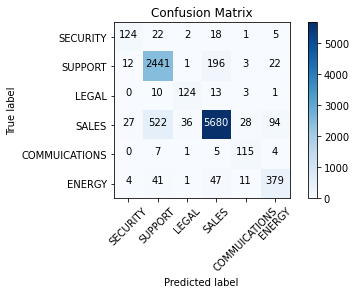

In [30]:
plot_confusion_matrix(cm=cm, classes=lookup, title='Confusion Matrix')

In [26]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [27]:
np.mean(recall)

0.833307210649278

In [28]:
np.mean(precision)

0.785693310232071